Importação das bibliotecas necessárias

In [10]:
import numpy as np 
import pandas as pd 
import spacy
from spacy import displacy
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from textblob import TextBlob

lendo nosso dataset

In [ ]:
df = pd.read_csv("imdb_labelled.txt", names=['sentence','label'], sep='\t')

Vamos ver como está a estrutura dos nossos dados

In [ ]:
df.sample(10)

Quel tal gerarmos um WordCloud com todos os Reviews apenas por diversão!

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud

# nltk.download()
stopwordsNltk = nltk.corpus.stopwords.words("english")

words = []
for i in df.sentence:
    for p in i.lower().split():
        if p not in stopwordsNltk:
            words.append(p)
words = str(words)

wordcloud = WordCloud(width=1000, height=800, margin=0).generate(words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

Vamos verificar se o Spacy consegue analisar gramaticalmente alguns Reviews!

In [ ]:
#!python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
neg = df[df["label"]==0]

frases_neg = []
for i in neg.sentence:
    frases_neg.append(i)

    neg_str = ''.join(frases_neg)
    doc_neg = nlp(neg_str)
    
    color = {'PERSON':'red','ORG':'orange'}
    options = {'ents':['PERSON', 'ORG'], 'colors':color}
    
    for sent in doc_neg.sents:
        if sent.ents:
            displacy.render(nlp(sent.text), style='ent', jupyter=True, options=options)

Vamos criar uma coluna de ID's

In [ ]:
df.head()
df["id"] = df.index

Para cada sentença, vamos verificar se as paralavras são do tipo STOPWORDS (variavel atribuída na nossa núvem de palavras. caso seja, ela será removida da sentença. vamos adicionar uma nova coluna no nosso dataframe com as sentenças sem stop words

In [ ]:
df['sentence'] = df['sentence'].map(lambda x: x.lower())
df['sentence_sem_stop'] = df['sentence'].apply(lambda x: ' '.join(p for p in x.split() if p not in stopwordsNltk))
df.head()
df.shape

Agora vamos adicionar uma nova coluna  denominada "col_pos", onde cada palavra da coluna "sentence_sem_stop" será unida a sua pos correspondente

In [2]:
def num_pos(frase_sem_stop):
    return TextBlob(frase_sem_stop).tags

In [ ]:
#nltk.download('averaged_perceptron_tagger')
sub_a = df['sentence_sem_stop'].apply(num_pos)
df_1 = pd.DataFrame(sub_a)
df_1['col_pos'] = df_1['sentence_sem_stop'].map(lambda x:" ".join(["/".join(x) for x in x]))
df = pd.merge(df, df_1, left_index=True, right_index=True)
print(df.head())

Agora vamos dividir nosso conjunto de dados em treino e teste.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['col_pos'],df['label'],test_size=0.2, random_state=42)

Tfidf = TfidfVectorizer(smooth_idf=True, lowercase=True, sublinear_tf=False, use_idf=True)
x_train_Tfidf = Tfidf.fit_transform(x_train)
x_test_Tfidf = Tfidf.transform(x_test)
print(Tfidf.get_feature_names())


Vamos criar uma função para escolher o melhor conjunto de parâmetros

In [ ]:
def selecao_params(x,y,n_folds):
    Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel='linear'),param_grid, cv=n_folds)
    grid_search.fit(x,y)
    return grid_search.best_params_

In [ ]:
selecao_params(x_train_Tfidf,y_train,5)


Utilizaremos o modelo SVM com kernel linear para esse exemplo

In [ ]:
clf = SVC(kernel='linear', C=0.9)
clf.fit(x_train_Tfidf, y_train)
predicao = clf.predict(x_test_Tfidf)


Um modelo com alto recall, mas baixa precisão retorna muitos resultados, mas a maioria incorretos. Um sistema com alta precisão, mas com baixo recall, é exatamente o oposto, retornando poucos resultados, mas a maioria de seus rótulos previstos estam corretos. Um sistema ideal com alta precisão e alto recall retornará muitos resultados, com todos os resultados detectados corretamente.
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [ ]:
print(accuracy_score(y_test,predicao))
print(classification_report(y_test,previsao))

In [ ]:
font = {'family': 'normal',
       'weight' : 'bold',
       'size' : 17}
plt.rc('font', **font)

cm = confusion_matrix(y_test, predicao)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='none', cmap=plt.cm.Wistia)
#classNames = ['Negativo', 'Positivo']
plt.ylabel('Labels')
plt.xlabel('Previsões')
s = [['TN', 'FP'],['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Vamos ler uma base de dados em português e analisarmos se tem o mesmo desempenho. Primeiramente, vamos transformar a variável "sentiment" para números substituindo os valores "pos" e "neg" para 1 e 0. Também vamos mudar o nome das nossas colunas para algo mais intuitivo como ID, SENTENSE, LABEL.

In [3]:
df = pd.read_csv("imdb-reviews-pt-br.csv")
df.sample(10)
df.drop('text_en', inplace=True, axis=1)
df.sample(10)
df["sentiment"] = df["sentiment"].replace("pos", 1)
df["sentiment"] = df["sentiment"].replace("neg", 0)
df.columns = ['id','sentence','label']
df

,id,sentence,label
0,1,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,Este é um exemplo do motivo pelo qual a maiori...,0
2,3,"Primeiro de tudo eu odeio esses raps imbecis, ...",0
3,4,Nem mesmo os Beatles puderam escrever músicas ...,0
4,5,Filmes de fotos de latão não é uma palavra apr...,0
...,...,...,...
49454,49456,"Como a média de votos era muito baixa, e o fat...",1
49455,49457,O enredo teve algumas reviravoltas infelizes e...,1
49456,49458,Estou espantado com a forma como este filme e ...,1
49457,49459,A Christmas Together realmente veio antes do m...,1


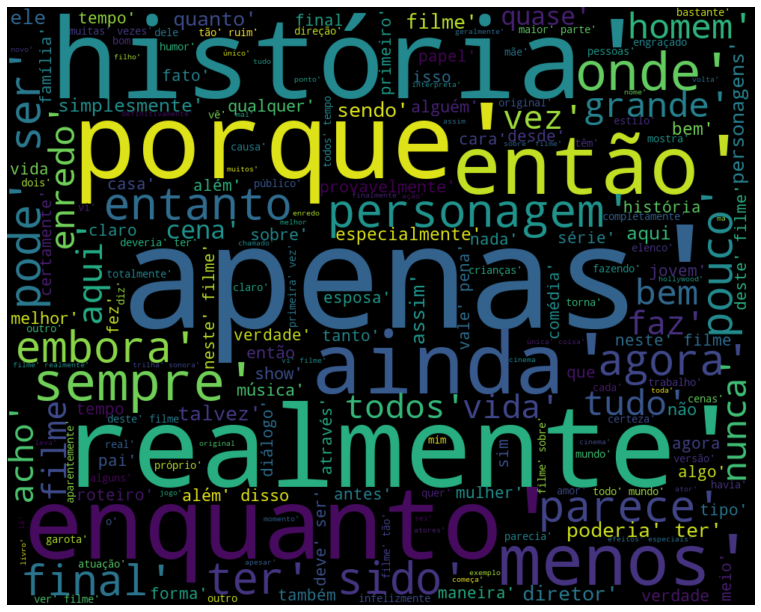

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud

# nltk.download()
stopwordsNltk = nltk.corpus.stopwords.words("portuguese")

words = []
for i in df.sentence:
    for p in i.lower().split():
        if p not in stopwordsNltk:
            words.append(p)
words = str(words)

wordcloud = WordCloud(width=1000, height=800, margin=0).generate(words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

In [5]:
#!python3 -m spacy download pt
nlp = spacy.load('pt_core_news_sm')
neg = df[df["label"]==0]

frases_neg = []
for i in neg.sentence:
    frases_neg.append(i)

    neg_str = ''.join(frases_neg)
    doc_neg = nlp(neg_str)
    
    color = {'PERSON':'red','ORG':'orange'}
    options = {'ents':['PERSON', 'ORG'], 'colors':color}
    
    for sent in doc_neg.sents:
        if sent.ents:
            displacy.render(nlp(sent.text), style='ent', jupyter=True, options=options)

KeyboardInterrupt: 

In [8]:
df['sentence'] = df['sentence'].map(lambda x: x.lower())
df['sentence_sem_stop'] = df['sentence'].apply(lambda x: ' '.join(p for p in x.split() if p not in stopwordsNltk))
print(df.sample(10))
df.shape

          id                                           sentence  label  \
39088  39090  eu nunca vou esquecer este filme ou os eventos...      1   
9507    9509  esse é o pior filme que vi desde muito tempo. ...      0   
24092  24094  tendo visto isso sem saber de todo o entusiasm...      1   
40598  40600  abc fez mais para este show, permitindo que os...      1   
14724  14726  o coletor da morte é verdadeiramente um filme ...      1   
277      278  esforço sério que consegue algum sucesso para ...      0   
3872    3874  isso geralmente soa muito melhor na minha cabe...      0   
14179  14181  sim barney é um absurdo agora, mas quando eu e...      1   
15908  15910  espero que o escritor, diretor, editor e compo...      1   
23838  23840  eu gostei muito dessa comédia. will smith não ...      1   

                                       sentence_sem_stop  
39088  nunca vou esquecer filme eventos levaram jones...  
9507   pior filme vi desde tempo. precisão histórica ...  
24092  t

(49459, 4)

In [9]:
sub_a = df['sentence_sem_stop'].apply(num_pos)
df_1 = pd.DataFrame(sub_a)
df_1['col_pos'] = df_1['sentence_sem_stop'].map(lambda x:" ".join(["/".join(x) for x in x]))
df = pd.merge(df, df_1, left_index=True, right_index=True)
df.sample(10)


,id,sentence,label,sentence_sem_stop_x,sentence_sem_stop_y,col_pos
20339,20341,quem não ama os muppets ?! impossível é assist...,1,ama muppets ?! impossível assisti-los sentir a...,"[(ama, NN), (muppets, NNS), (impossível, JJ), ...",ama/NN muppets/NNS impossível/JJ assisti-los/J...
13229,13231,no segundo de seus filmes de artes marciais hi...,1,"segundo filmes artes marciais históricas, chib...","[(segundo, NN), (filmes, NNS), (artes, VBZ), (...",segundo/NN filmes/NNS artes/VBZ marciais/JJ hi...
47995,47997,coloque-se no lugar de carlas. ela é uma drudg...,1,coloque-se lugar carlas. drudge administrativa...,"[(coloque-se, JJ), (lugar, NN), (carlas, NNS),...",coloque-se/JJ lugar/NN carlas/NNS drudge/NN ad...
6813,6815,desperdício de 1h45 este pequeno filme desagra...,0,desperdício 1h45 pequeno filme desagradável ev...,"[(desperdício, NN), (1h45, CD), (pequeno, NN),...",desperdício/NN 1h45/CD pequeno/NN filme/NN des...
16730,16732,"toda vez que ouço a voz de karen carpenters, h...",1,"toda vez ouço voz karen carpenters, antiga sen...","[(toda, NN), (vez, NN), (ouço, NN), (voz, NN),...",toda/NN vez/NN ouço/NN voz/NN karen/NN carpent...
16592,16594,minha sinopse rae christina ricci era uma puta...,1,sinopse rae christina ricci puta ensino médio ...,"[(sinopse, NN), (rae, NN), (christina, NN), (r...",sinopse/NN rae/NN christina/NN ricci/NN puta/N...
19340,19342,algumas pessoas acham que esta foi uma série d...,1,"algumas pessoas acham série tv bastante ruim, ...","[(algumas, RB), (pessoas, JJ), (acham, NN), (s...",algumas/RB pessoas/JJ acham/NN série/JJ tv/NN ...
30458,30460,"eu cresci lendo modesty blaise, tanto os quadr...",0,"cresci lendo modesty blaise, tanto quadrinhos ...","[(cresci, NN), (lendo, VBZ), (modesty, JJ), (b...",cresci/NN lendo/VBZ modesty/JJ blaise/NN tanto...
16485,16487,"este é um musical muito divertido, fofo e glam...",1,"musical divertido, fofo glamoroso anos 40. cov...","[(musical, JJ), (divertido, NN), (fofo, JJ), (...",musical/JJ divertido/NN fofo/JJ glamoroso/NN a...
41966,41968,este é um daqueles filmes que exploram o choqu...,1,daqueles filmes exploram choque cultural pesso...,"[(daqueles, NNS), (filmes, NNS), (exploram, VB...",daqueles/NNS filmes/NNS exploram/VBP choque/JJ...


In [12]:
x_train, x_test, y_train, y_test = train_test_split(df['col_pos'],df['label'],test_size=0.2, random_state=42)

Tfidf = TfidfVectorizer(smooth_idf=True, lowercase=True, sublinear_tf=False, use_idf=True)
x_train_Tfidf = Tfidf.fit_transform(x_train)
x_test_Tfidf = Tfidf.transform(x_test)
#print(Tfidf.get_feature_names())

In [ ]:
#Demora +- 30 min para rodar
selecao_params(x_train_Tfidf,y_train,5)

In [13]:
clf = SVC(kernel='linear', C=0.9)
clf.fit(x_train_Tfidf, y_train)
predicao = clf.predict(x_test_Tfidf)



0.8903154063890012


In [15]:
print(accuracy_score(y_test,predicao))
print(classification_report(y_test,predicao))

0.8903154063890012
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5038
           1       0.88      0.90      0.89      4854

    accuracy                           0.89      9892
   macro avg       0.89      0.89      0.89      9892
weighted avg       0.89      0.89      0.89      9892



In [ ]:
font = {'family': 'normal',
       'weight' : 'bold',
       'size' : 17}
plt.rc('font', **font)

cm = confusion_matrix(y_test, predicao)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='none', cmap=plt.cm.Wistia)
plt.ylabel('Labels')
plt.xlabel('Previsões')
s = [['TN', 'FP'],['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]))
plt.show()